In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import talib
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split


In [2]:
def add_technical_indicators(spread, timeperiod=22):

    # MACD
    macd, macdsignal, macdhist = talib.MACD(spread, fastperiod=12, slowperiod=26, signalperiod=9)

    rsi = talib.RSI(spread, timeperiod=14)

    # CMO
    cmo = talib.CMO(spread, timeperiod=timeperiod)

    # MOM
    mom = talib.MOM(spread, timeperiod=timeperiod)

    # Bollinger Bands
    upperband, middleband, lowerband = talib.BBANDS(spread, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0)

    # SMA
    sma = talib.SMA(spread, timeperiod=timeperiod)

    # Combine all indicators into a DataFrame
    indicators = pd.DataFrame({
        'MACD': macd,
        'MACD_signal': macdsignal,
        'MACD_hist': macdhist,
        'RSI': rsi,
        'CMO': cmo,
        'MOM': mom,
        'Upper_BB': upperband,
        'Middle_BB': middleband,
        'Lower_BB': lowerband,
        'SMA': sma
    })
    return indicators

In [3]:
# Load and preprocess data
data = pd.read_csv("Technology_Firm_Stock_Price.csv")
data = data.sort_values(by="Date")
selected_pairs = [('SWKS', 'QRVO'), ('AMAT', 'NXPI'), ('ANET', 'PANW'), ('CDNS', 'PANW')]
spreads_with_indicators = {}
for stock1, stock2 in selected_pairs:
    spread = data[stock1] - data[stock2]
    indicators = add_technical_indicators(spread)
    indicators['Spread'] = spread
    spreads_with_indicators[(stock1, stock2)] = indicators.dropna()  # Drop rows with NaN 22 column (because of our timeperiod is 22 day for calculate these indicators thus we dropped first 22 column


In [40]:
def rolling_window(data):
    time_step = 22

    X, y = [], []

    for i in range(len(data) - time_step):
        X.append(data.iloc[i : (i+time_step)])
        y.append(data.iloc[i+time_step])

    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(y.shape)

    return X, y

In [41]:
class RollingWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

In [53]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [43]:
# Parameters
look_back = 60
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
loss_fn = torch.nn.MSELoss()

# Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))

In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [77]:
def train_lstm(pair, x_train, y_train, batch_size, epochs, hidden_dim, num_layers, learning_rate):
    # Create the model
    model = LSTM(input_dim=x_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers, output_dim=y_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_loader = DataLoader(RollingWindowDataset(x_train, y_train), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Pair: {pair}, Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.6f}')
    return model  # Return the trained model


# Define fixed hyperparameters
batch_size = 32
epochs = 100
hidden_dim = 128
num_layers = 2
learning_rate = 0.001

# [Your existing code to load and preprocess data goes here]

# Example usage with one stock pair
pair = selected_pairs[0]  # Example: first pair in the list
spread_data = spreads_with_indicators[pair]
y = spread_data['Spread']
x = spread_data.drop(columns=['Spread'])

x, y = rolling_window(spread_data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Train the LSTM model
train_lstm(pair, x_train, y_train, batch_size, epochs, hidden_dim, num_layers, learning_rate)

(951, 22, 11)
(951, 11)
Pair: ('SWKS', 'QRVO'), Epoch 1/100, Loss: 318.692515
Pair: ('SWKS', 'QRVO'), Epoch 2/100, Loss: 265.898907
Pair: ('SWKS', 'QRVO'), Epoch 3/100, Loss: 234.914077
Pair: ('SWKS', 'QRVO'), Epoch 4/100, Loss: 210.991709
Pair: ('SWKS', 'QRVO'), Epoch 5/100, Loss: 191.351858
Pair: ('SWKS', 'QRVO'), Epoch 6/100, Loss: 174.982878
Pair: ('SWKS', 'QRVO'), Epoch 7/100, Loss: 161.118762
Pair: ('SWKS', 'QRVO'), Epoch 8/100, Loss: 149.286552
Pair: ('SWKS', 'QRVO'), Epoch 9/100, Loss: 139.152271
Pair: ('SWKS', 'QRVO'), Epoch 10/100, Loss: 130.485513
Pair: ('SWKS', 'QRVO'), Epoch 11/100, Loss: 122.955937
Pair: ('SWKS', 'QRVO'), Epoch 12/100, Loss: 116.318526
Pair: ('SWKS', 'QRVO'), Epoch 13/100, Loss: 110.455338
Pair: ('SWKS', 'QRVO'), Epoch 14/100, Loss: 105.320076
Pair: ('SWKS', 'QRVO'), Epoch 15/100, Loss: 100.654914
Pair: ('SWKS', 'QRVO'), Epoch 16/100, Loss: 96.374058
Pair: ('SWKS', 'QRVO'), Epoch 17/100, Loss: 92.470719
Pair: ('SWKS', 'QRVO'), Epoch 18/100, Loss: 89.04143

LSTM(
  (lstm): LSTM(11, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)

In [79]:
def test_lstm(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predictions.extend(output.numpy())  # Store predictions
            actuals.extend(target.numpy())  # Store actual values
    return np.array(predictions), np.array(actuals)

pair = selected_pairs[0]
spread_data = spreads_with_indicators[pair]
y = spread_data['Spread']
x = spread_data.drop(columns=['Spread'])
x, y = rolling_window(spread_data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Scaling data (make sure to scale x_train and x_test appropriately)

# Training
model = train_lstm(pair, x_train, y_train, batch_size, epochs, hidden_dim, num_layers, learning_rate)

# Testing
test_loader = DataLoader(RollingWindowDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
criterion = nn.MSELoss()
test_loss = test_lstm(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.6f}")


(951, 22, 11)
(951, 11)
Pair: ('SWKS', 'QRVO'), Epoch 1/100, Loss: 317.926637
Pair: ('SWKS', 'QRVO'), Epoch 2/100, Loss: 261.641853
Pair: ('SWKS', 'QRVO'), Epoch 3/100, Loss: 231.491529
Pair: ('SWKS', 'QRVO'), Epoch 4/100, Loss: 208.475318
Pair: ('SWKS', 'QRVO'), Epoch 5/100, Loss: 189.651977
Pair: ('SWKS', 'QRVO'), Epoch 6/100, Loss: 173.748996
Pair: ('SWKS', 'QRVO'), Epoch 7/100, Loss: 160.381396
Pair: ('SWKS', 'QRVO'), Epoch 8/100, Loss: 149.109338
Pair: ('SWKS', 'QRVO'), Epoch 9/100, Loss: 139.593522
Pair: ('SWKS', 'QRVO'), Epoch 10/100, Loss: 131.580339
Pair: ('SWKS', 'QRVO'), Epoch 11/100, Loss: 124.863497
Pair: ('SWKS', 'QRVO'), Epoch 12/100, Loss: 119.266174
Pair: ('SWKS', 'QRVO'), Epoch 13/100, Loss: 114.632723
Pair: ('SWKS', 'QRVO'), Epoch 14/100, Loss: 110.824570
Pair: ('SWKS', 'QRVO'), Epoch 15/100, Loss: 107.718494
Pair: ('SWKS', 'QRVO'), Epoch 16/100, Loss: 105.204823
Pair: ('SWKS', 'QRVO'), Epoch 17/100, Loss: 103.184577
Pair: ('SWKS', 'QRVO'), Epoch 18/100, Loss: 101.56

TypeError: test_lstm() takes 2 positional arguments but 3 were given

In [100]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [102]:
# Calculate MAPE
mape = mean_absolute_percentage_error(actuals[:, 3], predictions[:,3])
print(f"MAPE: {mape:.2f}%")

MAPE: 8.64%


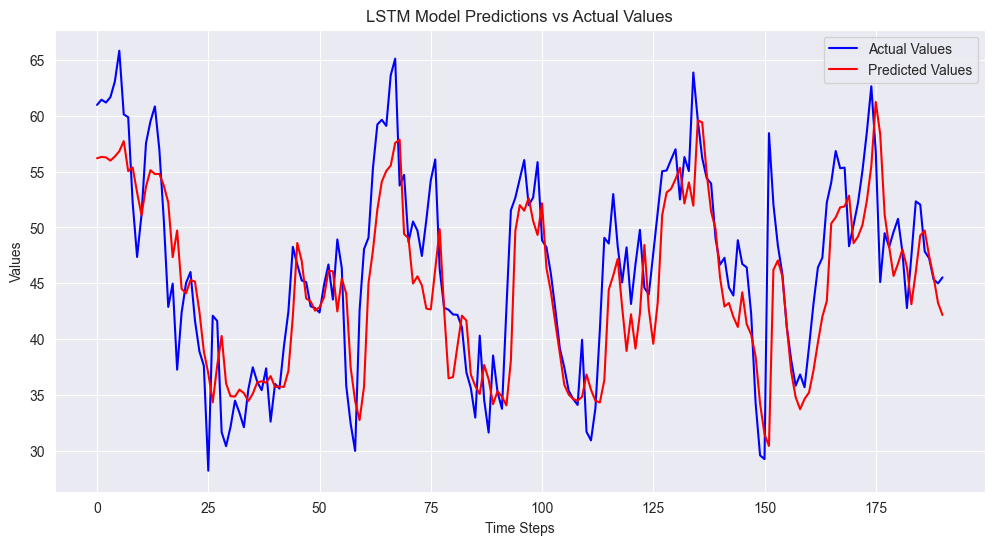

In [99]:
import matplotlib.pyplot as plt

# Assume test_loader is already created with test data
predictions, actuals = test_lstm(model, test_loader)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals[:, 3], label='Actual Values', color='blue')
plt.plot(predictions[:,3], label='Predicted Values', color='red')
plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


In [15]:
print(f"x_test shape: {x_test.shape}")
y_test_pred = model(x_test)


x_test shape: (183, 59, 11)


TypeError: 'int' object is not callable

In [13]:
x.shape

(21648, 1)

In [15]:
21648/984

22.0